In [1]:
import numpy as np
import networkx as nx
from sklearn.preprocessing import StandardScaler
from codefiles import *

In [2]:
G = nx.Graph()
with open("dataset/ca-GrQc.txt/CA-GrQc.txt", 'r') as f:
    for line in f:
        if line.startswith('#'):
            continue
        u, v = map(int, line.strip().split())
        G.add_edge(u, v)

In [3]:
G = G.subgraph(max(nx.connected_components(G), key=len))
    
# Create adjacency matrix
adj_matrix = nx.to_numpy_array(G)
adj_matrix.shape

(4158, 4158)

In [4]:
degree = np.array(list(dict(G.degree()).values()))
eigenvector = np.array(list(nx.eigenvector_centrality(G, max_iter=1000).values()))

In [5]:
node_features = degree #* eigenvector
#scaler = StandardScaler()
#node_features = scaler.fit_transform(node_features.reshape(-1,1)).flatten()

node_features.shape

(4158,)

In [6]:
nodes_to_keep = np.where(degree >= 10)[0]

filtered_adj_matrix = adj_matrix[np.ix_(nodes_to_keep, nodes_to_keep)]
filtered_node_features = node_features[nodes_to_keep]
filtered_adj_matrix.shape

(737, 737)

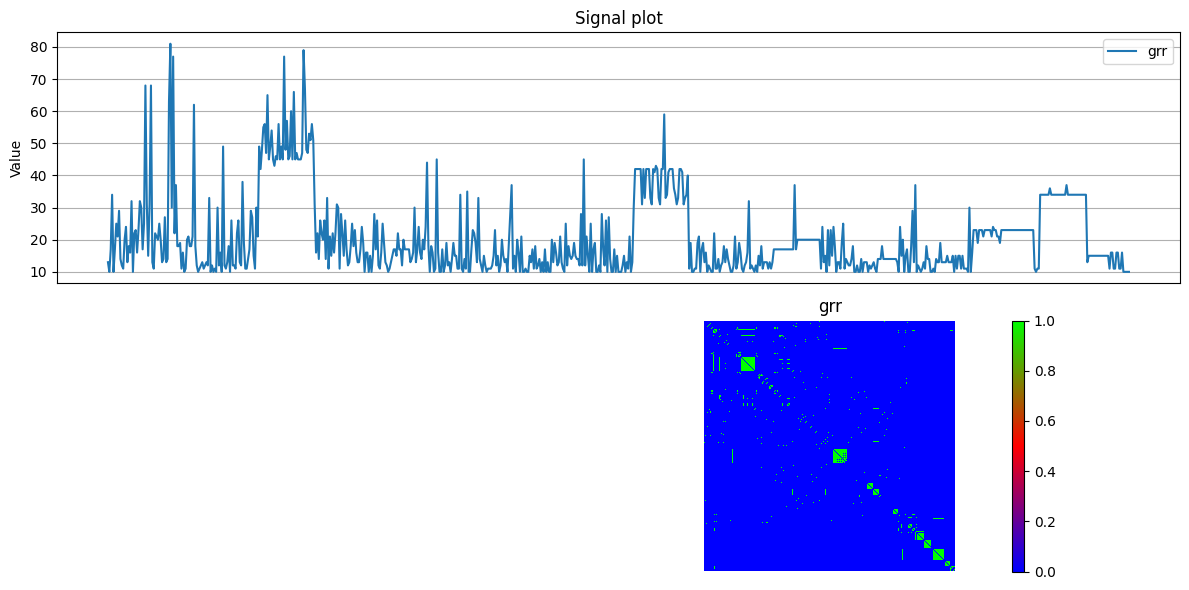

In [7]:
plot_arrays([("grr",filtered_node_features,filtered_adj_matrix)])

In [9]:
_,_,_ = VEMICL(filtered_adj_matrix,filtered_node_features,50)

16


In [10]:
theta, mu ,name,perm = VEMbasedV(filtered_adj_matrix,filtered_node_features,16,cluster=True)

In [26]:
thatF,muF,nameF = ir_ls(filtered_adj_matrix,filtered_node_features[:,None],16)

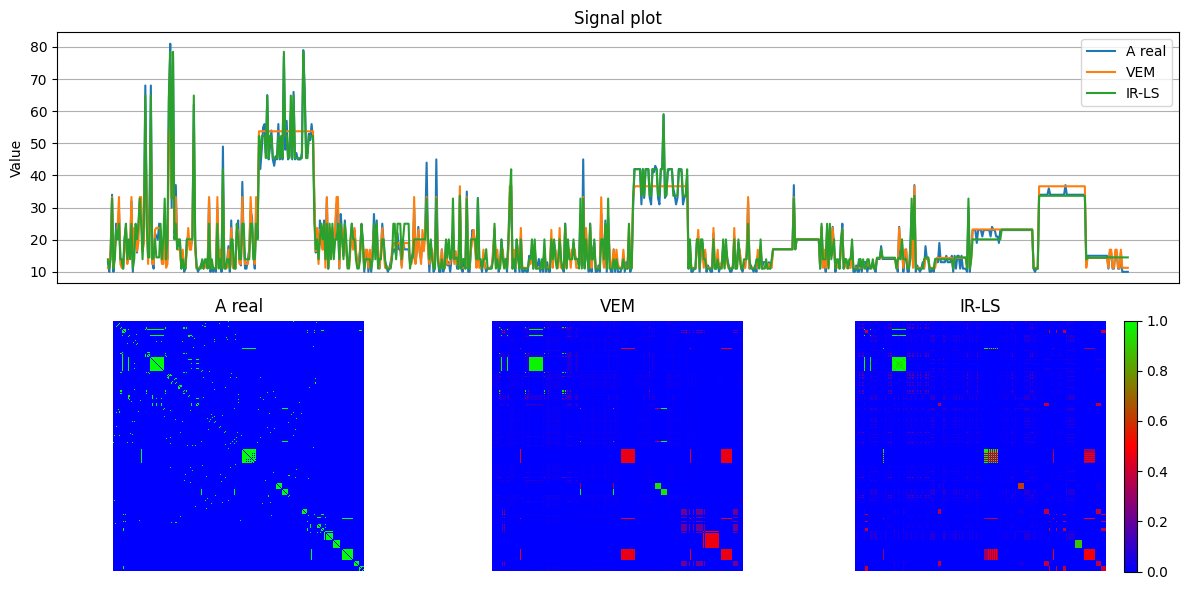

In [29]:
plot_arrays([("A real",filtered_node_features,filtered_adj_matrix),(name,mu,theta),(nameF,muF,thatF)])

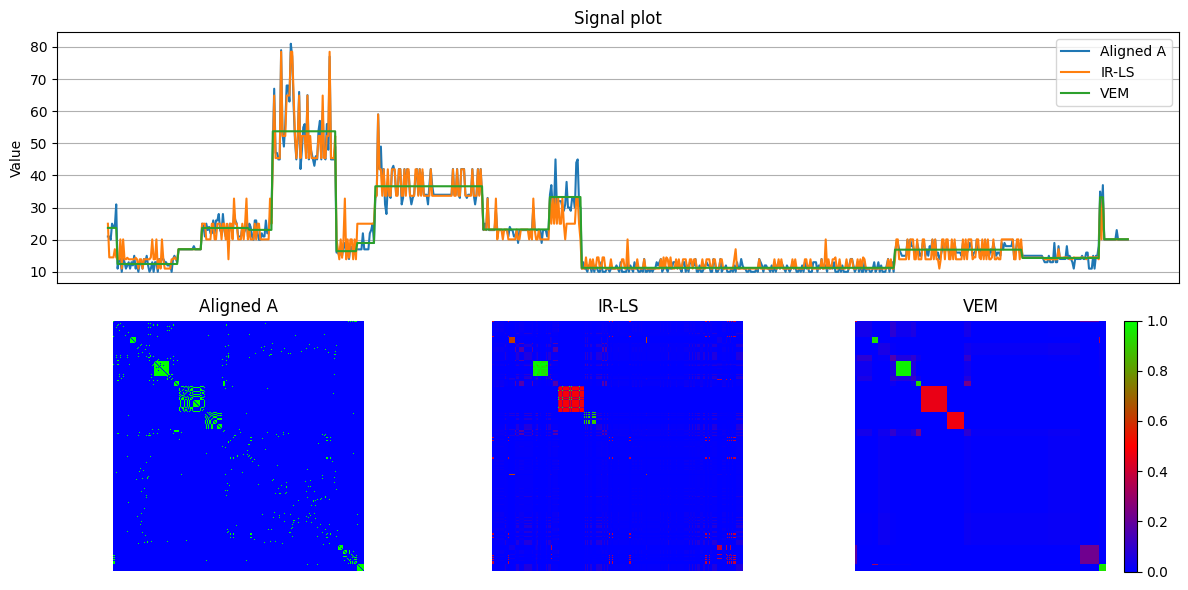

In [27]:
perm_adj_matrice = filtered_adj_matrix[perm,:]
perm_adj_matrice = perm_adj_matrice[:,perm]
perm_node_features = filtered_node_features[perm]

perm_theta = theta[perm,:]
perm_theta = perm_theta[:,perm]
perm_mu = mu[perm]

perm_thetaF = thatF[perm,:]
perm_thetaF = perm_thetaF[:,perm]
perm_muF = muF[perm]

plot_arrays([("Aligned A",perm_node_features,perm_adj_matrice),(nameF,perm_muF,perm_thetaF),("VEM",perm_mu,perm_theta)])